In [1]:
import findspark
findspark.init()

In [71]:
import pyspark
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.types import StringType, FloatType, ArrayType
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, explode
from surprise import Reader, Dataset, SVD, SVDpp, NMF, SlopeOne, KNNBasic, KNNBaseline, KNNWithMeans, KNNWithZScore, CoClustering, BaselineOnly
from surprise.model_selection.validation import cross_validate

In [3]:
spark = SparkSession.builder.appName('pj_2').getOrCreate()    

## Đọc dữ liệu

In [4]:
data = spark.read.csv('Data_Agoda/hotel_comments.csv',inferSchema=True,header=True)
data.count()

80314

In [5]:
data.printSchema()

root
 |-- num: integer (nullable = true)
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer ID: string (nullable = true)
 |-- Reviewer Name: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- Room Type: string (nullable = true)
 |-- Stay Details: string (nullable = true)
 |-- Score: string (nullable = true)
 |-- Score Level: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Review Date: string (nullable = true)



In [6]:
data.show(5)

+---+--------+-----------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+--------------------+--------------------+--------------------+
|num|Hotel ID|Reviewer ID|Reviewer Name|Nationality|       Group Name|           Room Type|        Stay Details|Score|      Score Level|               Title|                Body|         Review Date|
+---+--------+-----------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+--------------------+--------------------+--------------------+
|  1|     1_1|      1_1_1|       MARIKO|   Nhật Bản|          Cặp đôi|Phòng Deluxe 2 Gi...|Đã ở 3 đêm vào Th...| 10,0|Trên cả tuyệt vời|         Cao nhất‼︎”|Tôi đã ở cùng chủ...|Đã nhận xét vào 3...|
|  2|     1_1|      1_1_2|         Hong|   Việt Nam|      Đi công tác|Phòng Deluxe 2 Gi...|Đã ở 1 đêm vào Th...| 10,0|Trên cả tuyệt vời|            Tháng 8”|Lựa chọn Mường Th...|Đã nhận xét vào 0...|


## Tạo Dataframe chứa các cột cần dùng làm model

In [7]:
tmp = data.drop('num', 'Reviewer ID')
tmp = tmp.withColumn('Score', regexp_replace(col('Score'), ',', '.').cast(FloatType()))
tmp.count()

80314

In [8]:
tmp = tmp.dropDuplicates().dropna()
tmp.count()

31032

In [9]:
tmp.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer Name: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Group Name: string (nullable = true)
 |-- Room Type: string (nullable = true)
 |-- Stay Details: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- Score Level: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Review Date: string (nullable = true)



### Tạo cột Reviewer_name_idx bằng cách row_number() với 'Reviewer Name' 

In [10]:
windowSpec = Window.partitionBy('Hotel ID', 'Reviewer Name').orderBy('Reviewer Name')
data_pre = tmp.withColumn('row_num', row_number().over(windowSpec))
data_pre = data_pre.withColumn('Reviewer_name_idx', concat(col('Reviewer Name'), lit('_'), col('row_num').cast('string')))
data_pre = data_pre.drop('row_num')
data_pre.show()

+--------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+-------------------------+-------------------------------------+--------------------+-----------------+
|Hotel ID|Reviewer Name|Nationality|       Group Name|           Room Type|        Stay Details|Score|      Score Level|                    Title|                                 Body|         Review Date|Reviewer_name_idx|
+--------+-------------+-----------+-----------------+--------------------+--------------------+-----+-----------------+-------------------------+-------------------------------------+--------------------+-----------------+
|   10_10|         Diệu|   Việt Nam|          Cặp đôi|Phòng Hai Giường Đơn|Đã ở 1 đêm vào Th...| 10.0|Trên cả tuyệt vời|           Rất thoải mái”|                 Đây là lần thứ 2 ...|Đã nhận xét vào 3...|           Diệu_1|
|   10_10|          Han|   Việt Nam|      Đi công tác|    Phòng Tiêu Chuẩn|Đã ở 1 đêm vào Th...| 10.0|Tr

In [11]:
data_pre.select('Reviewer_name_idx').distinct().count()

9856

## Dataframe chứa 3 cột để build model

In [12]:
data_pre = data_pre.select('Hotel ID', 'Reviewer_name_idx', 'Score')
data_pre.show(20)

+--------+-----------------+-----+
|Hotel ID|Reviewer_name_idx|Score|
+--------+-----------------+-----+
|    10_1|           Dang_1|  9.2|
|    10_1|          HANJU_1|  7.6|
|    10_1|           한형_1|  7.6|
|    10_1|         훈앤후_1|  7.2|
|   10_10|           Diệu_1| 10.0|
|   10_10|            Han_1| 10.0|
|   10_10|        JOOHWAN_1|  9.2|
|   10_10|           Minh_1| 10.0|
|   10_10|            Sơn_1|  8.4|
|   10_10|         suyong_1|  8.8|
|   10_10|         김재광_1|  8.8|
|   10_10|        안정민[_1|  9.6|
|   10_12|           Adam_1|  9.6|
|   10_12|         Ahreum_1| 10.0|
|   10_12|         Akhoun_1| 10.0|
|   10_12|       Aljoscha_1| 10.0|
|   10_12|             An_1|  9.2|
|   10_12|     Anastasiia_1| 10.0|
|   10_12|        Andreas_1|  9.2|
|   10_12|        Andreas_2|  9.6|
+--------+-----------------+-----+
only showing top 20 rows



In [13]:
data_pre = data_pre.dropDuplicates().dropna()
data_pre.count()

31032

## Trực quan & chuẩn hóa dữ liệu  

### Biểu đồ top 10 khách sạn được đánh giá nhiều nhất

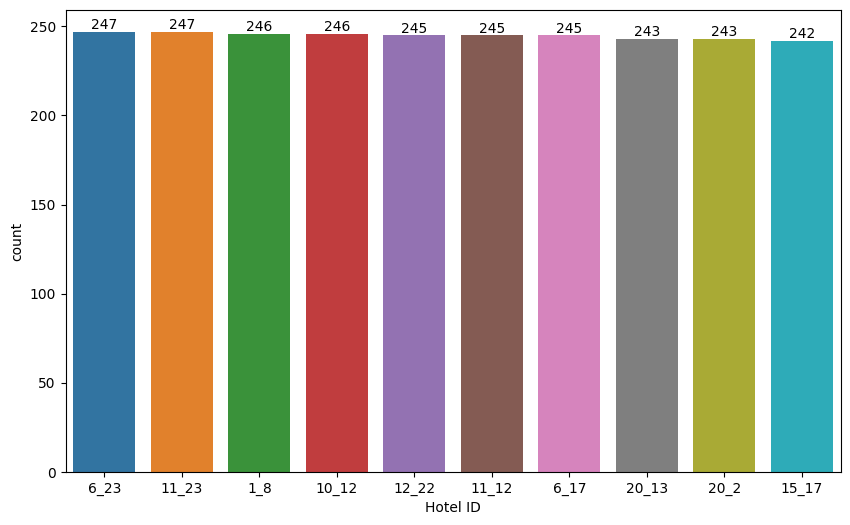

In [94]:
df_plt = data_pre.toPandas()
tmp = df_plt['Hotel ID'].value_counts().reset_index(name='count')
tmp = tmp.head(10)
plt.figure(figsize=(10,6))
sns.barplot(data = tmp,x='Hotel ID',y='count',errorbar=None,estimator='sum', hue = 'Hotel ID')
# Thêm số liệu lên trên đỉnh các cột
for index, value in zip(tmp['Hotel ID'], tmp['count']):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

### Biểu đồ top 10 khách hàng đánh giá nhiều nhất

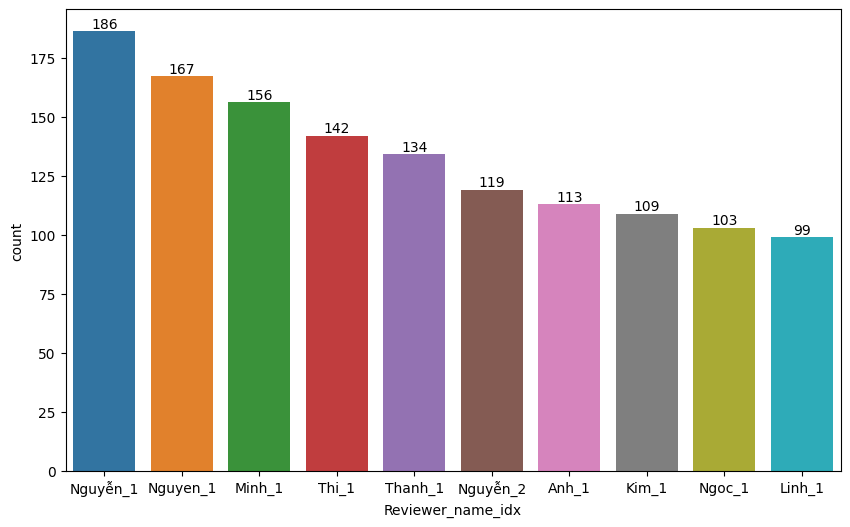

In [92]:
df_plt = data_pre.toPandas()
tmp = df_plt['Reviewer_name_idx'].value_counts().reset_index(name='count')
tmp = tmp.head(10)
plt.figure(figsize=(10,6))
sns.barplot(data = tmp,x='Reviewer_name_idx',y='count',errorbar=None,estimator='sum', hue = 'Reviewer_name_idx')
# Thêm số liệu lên trên đỉnh các cột
for index, value in zip(tmp['Reviewer_name_idx'], tmp['count']):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.show()

### Biểu đồ tần suất số điểm đánh giá

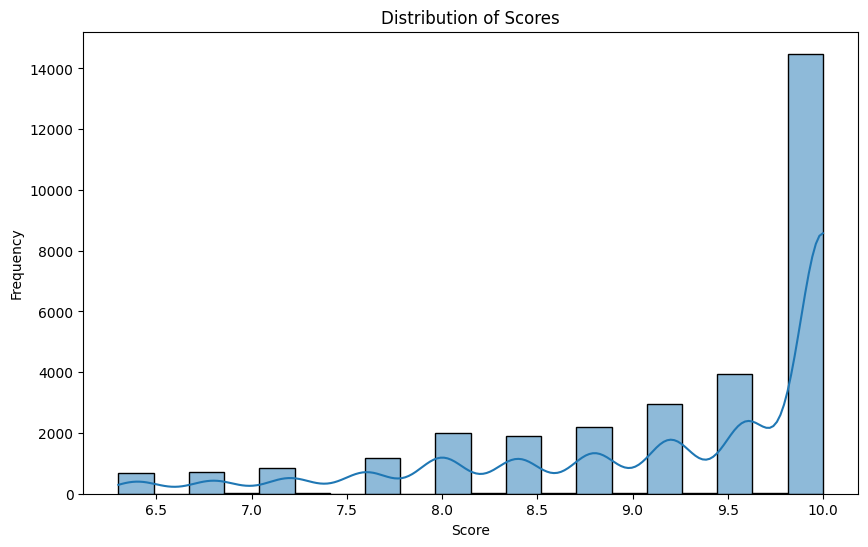

In [100]:
df_plt = data_pre.toPandas()
plt.figure(figsize=(10, 6))
sns.histplot(df_plt['Score'], bins=20, kde=True)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')
plt.show()
### Ta thấy được các đánh giá 10 rất nhiều

In [14]:
# Distinct reviewers and hotels
reviewers = data_pre.select("Reviewer_name_idx").distinct().count()
hotels = data_pre.select("Hotel ID").distinct().count()
numerator = data_pre.count()

In [15]:
display(numerator, reviewers, hotels)

31032

9856

473

In [16]:
# Tổng số ô trong ma trận 
denominator = reviewers * hotels
denominator

4661888

In [17]:
#Tỉ lệ còn trống khi đã được fill ban đầu
sparsity = 1 - (numerator*1.0 / denominator)
print ("Sparsity: "), sparsity

Sparsity: 


(None, 0.9933434694269789)

In [18]:
# Tạo indexer cho cột asin
indexer = StringIndexer(inputCol='Hotel ID', outputCol='Hotel_idx')
data_indexed = indexer.fit(data_pre).transform(data_pre)

# Tạo indexer cho cột reviewerID
indexer1 = StringIndexer(inputCol='Reviewer_name_idx', outputCol='Reviewer_idx')
final_data = indexer1.fit(data_indexed).transform(data_indexed)

In [19]:
final_data.show(5, truncate=True)

+--------+-----------------+-----+---------+------------+
|Hotel ID|Reviewer_name_idx|Score|Hotel_idx|Reviewer_idx|
+--------+-----------------+-----+---------+------------+
|   10_10|            Sơn_1|  8.4|    296.0|       232.0|
|    10_2|          Ghais_1| 10.0|     93.0|      4890.0|
|    10_2|         edward_1|  9.6|     93.0|      1467.0|
|    10_9|           성주_1| 10.0|    226.0|      2343.0|
|   11_11|       Virginie_1|  8.0|     44.0|      3385.0|
+--------+-----------------+-----+---------+------------+
only showing top 5 rows



In [20]:
final_data.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer_name_idx: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- Hotel_idx: double (nullable = false)
 |-- Reviewer_idx: double (nullable = false)



In [21]:
final_data.select([count(when(isnull(c), c)).alias(c) for c in final_data.columns]).toPandas().T

,0
Hotel ID,0
Reviewer_name_idx,0
Score,0
Hotel_idx,0
Reviewer_idx,0


In [22]:
final_data.select([count(when(isnan(c), c)).alias(c) for c in final_data.columns]).toPandas().T

,0
Hotel ID,0
Reviewer_name_idx,0
Score,0
Hotel_idx,0
Reviewer_idx,0


## Chuẩn bị train & test_data

In [23]:
train_data, test_data = final_data.randomSplit([0.8, 0.2])

In [24]:
train_data.describe().show()

+-------+--------+-----------------+------------------+-----------------+------------------+
|summary|Hotel ID|Reviewer_name_idx|             Score|        Hotel_idx|      Reviewer_idx|
+-------+--------+-----------------+------------------+-----------------+------------------+
|  count|   24806|            24806|             24806|            24806|             24806|
|   mean|    NULL|             NULL| 9.230770798966661|85.43126662904136|2025.7791663307264|
| stddev|    NULL|             NULL|0.9927851856126565|70.56877809220767|2651.4364264781966|
|    min|    10_1|        #Aperol_1|               6.3|              0.0|               0.0|
|    max|     9_7|           힝이_1|              10.0|            472.0|            9855.0|
+-------+--------+-----------------+------------------+-----------------+------------------+



In [25]:
train_data.show(5)

+--------+-----------------+-----+---------+------------+
|Hotel ID|Reviewer_name_idx|Score|Hotel_idx|Reviewer_idx|
+--------+-----------------+-----+---------+------------+
|    10_1|          HANJU_1|  7.6|    338.0|       963.0|
|    10_1|           한형_1|  7.6|    338.0|      1528.0|
|    10_1|         훈앤후_1|  7.2|    338.0|      1530.0|
|   10_10|           Diệu_1| 10.0|    296.0|       366.0|
|   10_10|            Han_1| 10.0|    296.0|       209.0|
+--------+-----------------+-----+---------+------------+
only showing top 5 rows



In [26]:
test_data.describe().show()

+-------+--------+-----------------+------------------+-----------------+------------------+
|summary|Hotel ID|Reviewer_name_idx|             Score|        Hotel_idx|      Reviewer_idx|
+-------+--------+-----------------+------------------+-----------------+------------------+
|  count|    6226|             6226|              6226|             6226|              6226|
|   mean|    NULL|             NULL| 9.250465807943838|86.91117892707999|2001.8340828782525|
| stddev|    NULL|             NULL|0.9695147656260281|71.40550627519657| 2657.111046817146|
|    min|    10_1|        10D5.14_1|               6.3|              0.0|               0.0|
|    max|     9_7|         히봉봉_1|              10.0|            467.0|            9850.0|
+-------+--------+-----------------+------------------+-----------------+------------------+



In [27]:
test_data.show()

+--------+-----------------+-----+---------+------------+
|Hotel ID|Reviewer_name_idx|Score|Hotel_idx|Reviewer_idx|
+--------+-----------------+-----+---------+------------+
|    10_1|           Dang_1|  9.2|    338.0|        72.0|
|   10_10|         김재광_1|  8.8|    296.0|      2327.0|
|   10_12|           Adam_1|  9.6|      2.0|       652.0|
|   10_12|            Anh_2| 10.0|      2.0|        55.0|
|   10_12|           Binh_1|  9.6|      2.0|       152.0|
|   10_12|            Chu_1| 10.0|      2.0|       294.0|
|   10_12|           Cole_1| 10.0|      2.0|      2515.0|
|   10_12|         Colten_2| 10.0|      2.0|      4450.0|
|   10_12|           Cris_1|  8.4|      2.0|      4461.0|
|   10_12|            Dao_2|  9.2|      2.0|       949.0|
|   10_12|         Dennis_1| 10.0|      2.0|      1184.0|
|   10_12|          Dipti_1| 10.0|      2.0|      4606.0|
|   10_12|          Dufay_1|  8.4|      2.0|      4645.0|
|   10_12|          FRANK_1| 10.0|      2.0|      4787.0|
|   10_12|       

## Xây dựng model với train_data

In [28]:
als = ALS(maxIter=15,
          regParam=0.2,
          rank = 13,
          userCol="Reviewer_idx",
          itemCol="Hotel_idx",
          ratingCol="Score",
          coldStartStrategy="drop",
          nonnegative=True)

start_time = time.time()
als_model = als.fit(train_data)
end_time = time.time()
elapsed_time = end_time - start_time

In [29]:
elapsed_time

12.381053686141968

## Đánh giá model với test_data

In [30]:
als_test_model = als_model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse",
                                labelCol="Score",
                                predictionCol="prediction")
rmse = evaluator.evaluate(als_test_model)

In [31]:
print("Root-mean-square error = " + str(rmse))
print('Time: ', elapsed_time)

Root-mean-square error = 1.1226595506067818
Time:  12.381053686141968


## Dự đoán mới

In [32]:
user_recs = als_model.recommendForAllUsers(5)

In [33]:
user_recs.show(10, truncate=False)

+------------+-------------------------------------------------------------------------------------------+
|Reviewer_idx|recommendations                                                                            |
+------------+-------------------------------------------------------------------------------------------+
|12          |[{427, 11.188049}, {335, 10.507856}, {323, 10.496542}, {438, 10.461822}, {437, 10.461822}] |
|26          |[{427, 11.143107}, {335, 10.770717}, {323, 10.761865}, {291, 10.522455}, {438, 10.459218}] |
|27          |[{427, 10.865218}, {323, 10.743484}, {335, 10.740802}, {291, 10.51724}, {393, 10.212828}]  |
|28          |[{291, 10.935393}, {335, 10.831904}, {323, 10.8308}, {427, 10.813758}, {337, 10.54305}]    |
|31          |[{427, 10.679679}, {438, 10.53931}, {437, 10.53931}, {381, 10.374757}, {365, 10.374757}]   |
|34          |[{427, 10.752102}, {291, 10.2793045}, {421, 10.219471}, {401, 10.219471}, {335, 10.078094}]|
|44          |[{427, 10.714137}, {335

In [34]:
df_reviewer_reviewer_id = final_data.select('Reviewer_idx', 'Reviewer_name_idx').distinct()
df_reviewer_reviewer_id.count()

9856

In [35]:
df_reviewer_reviewer_id.show(5)

+------------+-----------------+
|Reviewer_idx|Reviewer_name_idx|
+------------+-----------------+
|      4322.0|        Cecilia_1|
|       809.0|            JAE_2|
|       283.0|          Phước_1|
|      1511.0|             ye_1|
|      1761.0|          JiAhn_1|
+------------+-----------------+
only showing top 5 rows



In [36]:
df_hotel_hotel_idx = final_data.select('Hotel_idx', 'Hotel ID').distinct()
df_hotel_hotel_idx.count()

473

In [37]:
df_hotel_hotel_idx.show(5)

+---------+--------+
|Hotel_idx|Hotel ID|
+---------+--------+
|    297.0|   12_21|
|    181.0|    5_18|
|    349.0|   17_10|
|    277.0|    2_24|
|    344.0|    5_27|
+---------+--------+
only showing top 5 rows



In [38]:
new_user_recs = user_recs.join(df_reviewer_reviewer_id, on=['Reviewer_idx'], how='left')
new_user_recs.count()

8601

In [39]:
new_user_recs.show(5)

+------------+--------------------+-----------------+
|Reviewer_idx|     recommendations|Reviewer_name_idx|
+------------+--------------------+-----------------+
|          12|[{427, 11.188049}...|            Thị_1|
|          26|[{427, 11.143107}...|         NGUYEN_1|
|          27|[{427, 10.865218}...|          Quang_1|
|          28|[{291, 10.935393}...|           Ngọc_1|
|          31|[{427, 10.679679}...|         Nguyen_3|
+------------+--------------------+-----------------+
only showing top 5 rows



In [40]:
final_data.printSchema()

root
 |-- Hotel ID: string (nullable = true)
 |-- Reviewer_name_idx: string (nullable = true)
 |-- Score: float (nullable = true)
 |-- Hotel_idx: double (nullable = false)
 |-- Reviewer_idx: double (nullable = false)



In [41]:
# Gợi ý cho reviewerID = 'A1WGVOVABHFDF3'
Reviewer_name_idx = 'Nguyen_1'
find_user_rec = new_user_recs.filter(new_user_recs['Reviewer_name_idx'] == Reviewer_name_idx)
user = find_user_rec.first()
lst = []
for row in user['recommendations']:
    row_f = df_hotel_hotel_idx.filter(df_hotel_hotel_idx.Hotel_idx == row['Hotel_idx'])
    row_f_first = row_f.first()
    lst.append((row['Hotel_idx'], row_f_first['Hotel ID'], row['rating']))
dic_user_rec = {'Reviewer_name_idx' : user.Reviewer_name_idx, 'recommendations' :lst}
dic_user_rec

{'Reviewer_name_idx': 'Nguyen_1',
 'recommendations': [(427, '18_30', 10.855122566223145),
  (335, '7_9', 10.736937522888184),
  (323, '12_13', 10.72379207611084),
  (291, '39_17', 10.32441520690918),
  (438, '28_27', 10.181641578674316)]}

## Surprise

In [42]:
df = final_data.toPandas()
df.head()

,Hotel ID,Reviewer_name_idx,Score,Hotel_idx,Reviewer_idx
0,10_10,Sơn_1,8.4,296.0,232.0
1,10_2,Ghais_1,10.0,93.0,4890.0
2,10_2,edward_1,9.6,93.0,1467.0
3,10_9,성주_1,10.0,226.0,2343.0
4,11_11,Virginie_1,8.0,44.0,3385.0


In [43]:
# df.to_csv('final_hotel.csv',index = False)

In [44]:
df_tmp = df[['Hotel_idx', 'Score', 'Reviewer_idx']]
df_tmp.head()

,Hotel_idx,Score,Reviewer_idx
0,296.0,8.4,232.0
1,93.0,10.0,4890.0
2,93.0,9.6,1467.0
3,226.0,10.0,2343.0
4,44.0,8.0,3385.0


In [45]:
reader = Reader(rating_scale=(df_tmp['Score'].min(), df_tmp['Score'].max()))
df_pre = Dataset.load_from_df(df_tmp[['Reviewer_idx', 'Hotel_idx', 'Score']], reader)

In [46]:
algorithms = {
    'SVD' : SVD(),
    'SVD++' : SVDpp(),
    'BaselineOnly' : BaselineOnly(),
    'KNN Basicc' : KNNBasic(),
    'KNN Baseline' : KNNBaseline()
}

In [47]:
results = {}
for name, algorithm in algorithms.items():
    print(f'Evaluate {name}: ')
    start_time = time.time()
    result = cross_validate(algorithm, df_pre, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    end_time = time.time()
    elapsed_time = end_time - start_time
    result['fit_time'] = elapsed_time
    results[name] = result

Evaluate SVD: 
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9556  0.9661  0.9482  0.9427  0.9321  0.9489  0.0115  
MAE (testset)     0.7550  0.7641  0.7596  0.7479  0.7401  0.7533  0.0085  
Fit time          0.28    0.27    0.29    0.30    0.28    0.29    0.01    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    
Evaluate SVD++: 
Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9422  0.9355  0.9488  0.9526  0.9501  0.9458  0.0062  
MAE (testset)     0.7426  0.7417  0.7466  0.7560  0.7531  0.7480  0.0057  
Fit time          0.62    0.61    0.61    0.61    0.63    0.62    0.01    
Test time         0.15    0.15    0.15    0.22    0.19    0.17    0.03    
Evaluate BaselineOnly: 
Estimating biases using als...
Estimating biases using als...
Estimating biases usin

In [48]:
for name, result in results.items():
    print(f'{name} Result ')
    print(f"Mean RMSE: {result['test_rmse'].mean()}")
    print(f"Mean MSE: {result['test_mae'].mean()}")
    print(f"Time: {result['fit_time']}\n")

SVD Result 
Mean RMSE: 0.9489455850409507
Mean MSE: 0.7533250276362883
Time: 1.8935790061950684

SVD++ Result 
Mean RMSE: 0.9458433745312089
Mean MSE: 0.7480073679948107
Time: 4.141406059265137

BaselineOnly Result 
Mean RMSE: 0.9502178036877821
Mean MSE: 0.7605432467608823
Time: 0.7762386798858643

KNN Basicc Result 
Mean RMSE: 0.9265568187601196
Mean MSE: 0.707719639765214
Time: 10.137149333953857

KNN Baseline Result 
Mean RMSE: 0.9213502901313187
Mean MSE: 0.7059984194477857
Time: 9.48210620880127



In [49]:
# If the results are OK => getting full dataset => fit model
algorithm = SVD()
trainset = df_pre.build_full_trainset()
algorithm.fit(trainset)

In [50]:
# userId = 27 has seen some movies:
Reviewer_idx = 2097.0
df_select = df[(df['Reviewer_idx'] == Reviewer_idx) & (df['Score'] >=8)]
df_select = df_select.set_index('Hotel_idx')
df_select.head(df_select.shape[0])

,Hotel ID,Reviewer_name_idx,Score,Reviewer_idx
Hotel_idx,,,,
255.0,13_9,YUKA_1,8.8,2097.0
254.0,12_24,YUKA_1,8.8,2097.0
257.0,7_16,YUKA_1,8.8,2097.0


In [51]:
df_info = pd.read_csv('Data_Agoda/hotel_info.csv')
df_info = df_info[['Hotel_ID', 'Hotel_Name', 'Hotel_Address']]
df_info.rename(columns={'Hotel_ID': 'Hotel ID'}, inplace=True)
df_info.dropna().count()

Hotel ID         740
Hotel_Name       740
Hotel_Address    740
dtype: int64

In [52]:
df_info.head()

,Hotel ID,Hotel_Name,Hotel_Address
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"
1,1_2,ALPHA BIRD NHA TRANG,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,..."
2,1_3,Khách sạn Aaron (Aaron Hotel),"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam..."
3,1_4,Panorama Star Beach Nha Trang,"02 Nguyen Thi Minh Khai, Lộc Thọ, Nha Trang, V..."
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,"98B/13 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"


In [53]:
df_score = df[['Hotel_idx', 'Hotel ID']]
df_score

,Hotel_idx,Hotel ID
0,296.0,10_10
1,93.0,10_2
2,93.0,10_2
3,226.0,10_9
4,44.0,11_11
...,...,...
31027,66.0,6_5
31028,306.0,7_14
31029,15.0,7_26
31030,146.0,8_15


In [54]:
Reviewer_idx = 'NHƯ_1'
df_select = df[(df['Reviewer_name_idx'] == Reviewer_idx)]
Reviewer_idx = df_select['Reviewer_idx'].head(1).values[0]
Reviewer_idx

3000.0

In [56]:
Reviewer_idx = 3007.0
df_score = df[['Hotel_idx', 'Hotel ID']]
df_score['EstimateScore'] = df_score['Hotel_idx'].apply(lambda x: algorithm.predict(Reviewer_idx, x).est) # est: get EstimateScore
df_score = df_score.sort_values(by=['EstimateScore'], ascending=False)
df_score = df_score.drop_duplicates()

df_rcm = pd.merge(df_score, df_info, on='Hotel ID', how='left')
df_rcm = df_rcm.dropna(subset='Hotel_Name')
df_rcm

C:\Users\Phú\AppData\Local\Temp\ipykernel_58108\88048154.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_score['EstimateScore'] = df_score['Hotel_idx'].apply(lambda x: algorithm.predict(Reviewer_idx, x).est) # est: get EstimateScore


,Hotel_idx,Hotel ID,EstimateScore,Hotel_Name,Hotel_Address
1,96.0,10_22,9.698793,Khách sạn Sunrise Nha Trang Beach Hotel & Spa ...,"12 Trần Phú , Xương Huân, Nha Trang, Việt Nam,..."
2,8.0,20_2,9.698440,Khách Sạn MerPerle Beach (MerPerle Beach Hotel),"88A Tran Phu Street, Lộc Thọ, Nha Trang, Việt ..."
3,248.0,16_15,9.689823,HANZ Muong Thanh Vien Trieu Condo Hotel,"5 Phạm Văn Đồng, Vĩnh Hải, Nha Trang, Khánh Hò..."
4,53.0,2_4,9.673235,Khu nghỉ dưỡng Amiana Nha Trang (Amiana Resort...,"Nha Trang Bay, Phạm Văn Đồng , Vĩnh Hòa, Nha T..."
5,93.0,10_2,9.671238,InterContinental Nha Trang,"32-34 Tran Phu Street , Lộc Thọ, Nha Trang, Vi..."
...,...,...,...,...,...
467,103.0,6_10,8.410278,Khách sạn Starlet (Starlet Hotel Nha Trang),"51 Tuệ Tĩnh, Lộc Thọ, Nha Trang, Việt Nam"
468,147.0,1_29,8.399512,Khách sạn Paris Nha Trang (Paris Nha Trang Hot...,"96B1/6 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam"
470,189.0,33_29,8.327485,Hong Mai Hotel Nha Trang,"Đinh Tiên Hoàng. thị trấn Cam Đức, quận Cam Lâ..."
471,139.0,12_5,8.281169,Khách sạn Nice Swan (Nice Swan Hotel Nha Trang),"64 Hùng Vương, Lộc Thọ, Nha Trang, Việt Nam"


## Lưu và tải model

In [ ]:
# Save cosine_sim to file
import pickle
with open('surprise_svd.pkl', 'wb') as f:
    pickle.dump(algorithm, f)

# Open and read file to cosine_new
with open('surprise_svd.pkl', 'rb') as f:
    surprise_svd = pickle.load(f)
# cosine_sim_new